<a href="https://colab.research.google.com/github/ZohebAbai/Deep-Learning-Projects/blob/master/Tensorflow_Keras/02_TF_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification

We're going to classify the images of following ten categories airplane,automobile, bird, cat, deer, dog, frog, horse, ship, truck.

Steps covered:
1. Import Libraries
2. Downloading and View Dataset
3. Data Preprocessing -- Normalization and One hot encoding 
4. Data Augmentation  and Hyperparameter Setting
5. Model Building with L2 regularizers and Custom Initializers
6. Finding Max Learning rate for OneCycle LR
7. Model Training with OneCycleLR policy
8. Model Evaluation and Misclassified Images
9. GRAD-CAM Visualization
10. Gradio App

## Check the GPU

In [2]:
!nvidia-smi

Wed Jan 26 18:19:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [88]:
#!pip install -q gradio

     |████████████████████████████████| 871 kB 4.4 MB/s 
     |████████████████████████████████| 52 kB 925 kB/s 
     |████████████████████████████████| 210 kB 48.4 MB/s 
     |████████████████████████████████| 2.0 MB 53.3 MB/s 
     |████████████████████████████████| 1.1 MB 56.2 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 71.3 MB/s 
     |████████████████████████████████| 144 kB 70.5 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 10.9 MB 48.7 MB/s 
     |████████████████████████████████| 58 kB 7.1 MB/s 
     |████████████████████████████████| 79 kB 9.6 MB/s 
     |████████████████████████████████| 61 kB 563 kB/s 
     |████████████████████████████████| 856 kB 74.0 MB/s 
     |████████████████████████████████| 3.6 MB 47.0 MB/s 
     |████████████████████████████████| 58 kB 7.6 MB/s 


## Import libraries

In [3]:
import numpy as np
import os
import time
import math
import matplotlib.pyplot as plt
from collections import namedtuple
%matplotlib inline
np.random.seed(101)

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
tf.random.set_seed(101)

# tf.keras imports
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Add, Softmax, GlobalMaxPool2D
from tensorflow.keras.layers import BatchNormalization, MaxPool2D, Input, ReLU, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

# Image Augmenters
from albumentations import (Compose, HorizontalFlip, Cutout, PadIfNeeded, RandomCrop)

## Downloading and View Dataset

### Download Dataset

In [4]:
from tensorflow.keras.datasets import cifar10

(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170508288/170498071 [==============================] - 11s 0us/step


### View Data

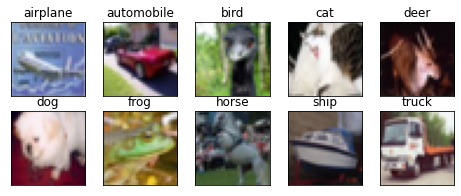

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Data Preprocessing - Image Normalization and One hot encoding

In [6]:
#Image Normalization
train_features = train_features.astype('float32')
test_features = test_features.astype('float32')

mean = np.mean(train_features, axis=(0,1,2))
std = np.std(train_features, axis=(0,1,2))
X_train = (train_features - mean) / (std)
X_test = (test_features - mean) / (std)

# convert class labels to binary class labels
y_train = to_categorical(train_labels, num_classes)
y_test = to_categorical(test_labels, num_classes)

## Data Augmentation and Hyperparameter Setting

### Setting Hyperparams

In [7]:
def get_hparams(**kwargs):
    return namedtuple('GenericDict', kwargs.keys())(**kwargs)

hparams = get_hparams(
    learning_rate= 1e-03,  # fixed learning rate
    batch_size= 512,  # training batch size
    momentum = 0.9, # fixed momentum
    n_epochs= 30,  # number of epochs to train
    decay = 1e-04 # learning rate*batch size
    )

### Image Augmentation techniques

* Random Crop of 32x32 with padding of 4px
* Horizontal Flip
* CutOut of 8x8


In [8]:
# Custom Image augmentation 

def CustomImageDataGen(input_img):
    seq = Compose([PadIfNeeded(40,40, p=1),
                   RandomCrop(32,32, p=1),
                   HorizontalFlip(p=0.5),
                   Cutout(num_holes=1, p=0.5)
                  ], p=1)
    output_img = seq(image = input_img)['image']
    return output_img

datagen = ImageDataGenerator(preprocessing_function=CustomImageDataGen)
datagen.fit(X_train)

## Model Building - Network Architecture (ResNet 9)

In [9]:
# PyTorch’s default way to set the initial, random weights of layers does not have 
# a counterpart in Tensorflow, so we borrow that

def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [10]:
# Linear layer to be used at end as prescribed by David
def linear_layer(x):
    return tf.math.multiply(x, 0.2)

In [11]:
def Resnet9(input_dim, n_classes):  
    inputs = Input(shape= input_dim, name='input')

    # Define the repeated conv_bn_relu function
    def conv_bn_relu(x, layer_name, pool=False):
        channels = {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 256}
        conv_layer = Conv2D(filters = channels[layer_name], 
                            kernel_size = 3, 
                            strides = 1, 
                            padding = 'same',
                            kernel_initializer=init_pytorch,
                            kernel_regularizer=l2(hparams.decay),
                            use_bias=False)
        x = conv_layer(x)
        x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
        x = ReLU()(x)
        if pool==True:
            x = MaxPool2D(2)(x)
        return x

    # Stack the layers
    # Layer Prep
    layer_prep = conv_bn_relu(inputs, 'prep')

    # Layer 1
    layer1_part1 = conv_bn_relu(layer_prep, 'layer1', pool=True)  
    layer1_part2_res1 = conv_bn_relu(layer1_part1, 'layer1')
    layer1_part2_res2 = conv_bn_relu(layer1_part2_res1, 'layer1')
    layer1 = Add()([layer1_part1, layer1_part2_res2])
    
    # Layer 2
    layer2_part1 = conv_bn_relu(layer1, 'layer2', pool=True)  
    layer2_part2_res1 = conv_bn_relu(layer2_part1, 'layer2')
    layer2_part2_res2 = conv_bn_relu(layer2_part2_res1, 'layer2')
    layer2 = Add()([layer2_part1, layer2_part2_res2])

    # Layer 3
    layer3 = conv_bn_relu(layer2, 'layer3', pool=True)

    # Layer Classifier
    layer_classifier = GlobalMaxPool2D()(layer3)
    layer_classifier = Flatten()(layer_classifier)
    layer_classifier = Dense(n_classes, kernel_initializer= init_pytorch,
                           kernel_regularizer=l2(hparams.decay),
                           use_bias=False, name='classifier')(layer_classifier)
    layer_classifier = Lambda(linear_layer)(layer_classifier)

    outputs = Softmax()(layer_classifier)

    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy',
                optimizer=SGD(learning_rate=hparams.learning_rate, momentum=hparams.momentum, 
                              nesterov=True),
                metrics=['accuracy'])
    return model

In [12]:
# Model Summary
input_dim = X_train.shape[1:]
net = Resnet9(input_dim, num_classes)
net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1728        ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

## Finding Max Learning rate for OneCycle LR

In [13]:
class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

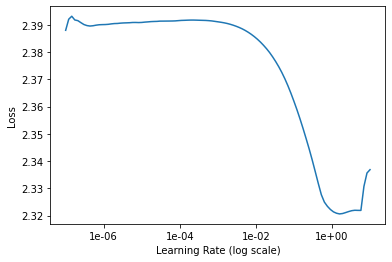

In [14]:
lr_finder = LRFinder()
net.fit(X_train, y_train, epochs=3, batch_size=512, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

A good max learning rate would be in the range where the loss is strictly decreasing at a rapid rate: 1.0.

## Model Training with OneCycleLR policy

In [15]:
class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """`Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=10.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []
    
    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

In [16]:
# train the model
start = time.time()

#checkpointer
checkpointer = ModelCheckpoint(filepath="bestmodel.h5", verbose=0, 
                               save_best_only=True, monitor="val_accuracy")
# one cycle lr
max_lr=1.0
steps = np.ceil(num_train / hparams.batch_size) * hparams.n_epochs
lr_scheduler = OneCycleScheduler(max_lr, steps)

# Fit the model
history = net.fit(datagen.flow(X_train, y_train, 
                               batch_size= hparams.batch_size, 
                               shuffle=True), 
                  epochs = hparams.n_epochs, 
                  validation_data=(X_test, y_test),
                  callbacks = [lr_scheduler, checkpointer])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/30
98/98 [==============================] - 14s 139ms/step - loss: 2.4981 - accuracy: 0.1997 - val_loss: 2.3498 - val_accuracy: 0.2517


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/30
98/98 [==============================] - 14s 143ms/step - loss: 2.2544 - accuracy: 0.2868 - val_loss: 2.1081 - val_accuracy: 0.3460
Epoch 3/30
98/98 [==============================] - 12s 122ms/step - loss: 2.0131 - accuracy: 0.3744 - val_loss: 1.8972 - val_accuracy: 0.4085
Epoch 4/30
98/98 [==============================] - 12s 122ms/step - loss: 1.7213 - accuracy: 0.4781 - val_loss: 1.6596 - val_accuracy: 0.5052
Epoch 5/30
98/98 [==============================] - 13s 132ms/step - loss: 1.4627 - accuracy: 0.5688 - val_loss: 1.3872 - val_accuracy: 0.5939
Epoch 6/30
98/98 [==============================] - 14s 140ms/step - loss: 1.2505 - accuracy: 0.6390 - val_loss: 1.1917 - val_accuracy: 0.6528
Epoch 7/30
98/98 [==============================] - 14s 140ms/step - loss: 1.0864 - accuracy: 0.6942 - val_loss: 1.3309 - val_accuracy: 0.6209
Epoch 8/30
98/98 [==============================] - 12s 125ms/step - loss: 0.9600 - accuracy: 0.7391 - val_loss: 1.1318 - val_accuracy: 0.6847

## Model Evaluation and Misclassified Images

In [17]:
# load the model
from tensorflow.keras.models import load_model
bestmodel = load_model("bestmodel.h5", custom_objects={'init_pytorch': init_pytorch})

# Evaluation
score= net.evaluate(X_test, y_test, batch_size=hparams.batch_size, verbose=1)
print("Minimal Validation Loss : ", score[0])
print("Max Validation Accuracy:", score[1]*100, "%")

20/20 [==============================] - 1s 42ms/step - loss: 0.4621 - accuracy: 0.9248
Minimal Validation Loss :  0.4620688557624817
Max Validation Accuracy: 92.47999787330627 %


### Plot Loss and Accuracy History

In [18]:
def plot_model_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
    axs[0].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(history.history['accuracy'])+1),len(history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(history.history['loss'])+1), history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1), history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

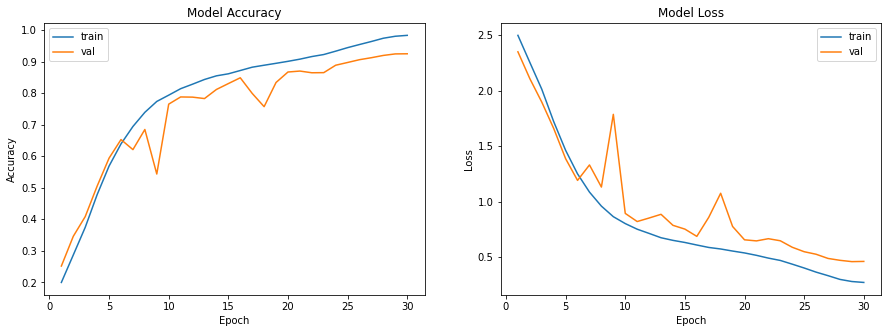

In [19]:
# plot model history
plot_model_history(history)

### Misclassified Images

In [20]:
#Prediction on validation dataset
valid_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=hparams.batch_size,
                                            shuffle=False, seed=101)
pred_valid = net.predict(valid_generator, steps= np.ceil(X_test.shape[0]/512), 
                                         verbose=0)
pred_labels = np.argmax(pred_valid, axis=1)
pred_labels[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

In [21]:
# True labels of validation dataset
true_labels = np.argmax(y_test,axis=1)
true_labels[:10]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

In [22]:
# Generate the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(true_labels, pred_labels))

[[934   4  16   7   2   1   3   1  20  12]
 [  2 972   0   0   0   0   0   1   4  21]
 [ 22   0 884  31  16  14  22   7   3   1]
 [  8   2  14 851  16  73  19   5   7   5]
 [  1   1  18  17 926  18   9   9   1   0]
 [  6   1  11  63  10 891   6   8   1   3]
 [  7   1   9  23   2   7 948   1   1   1]
 [  4   0   7  15  11  18   0 941   1   3]
 [ 22   8   2   4   1   0   2   1 951   9]
 [  8  24   1   3   0   1   1   1  11 950]]


In [23]:
# Total number of false predictions
mislabelled_index = []

for i in range(true_labels.shape[0]):
    if pred_labels[i] != true_labels[i]:
        mislabelled_index.append(i)

print('Number of False predictions: ', len(mislabelled_index),'out of', len(test_labels))

Number of False predictions:  752 out of 10000


## Grad CAM Visualization of any 25 misclassified images

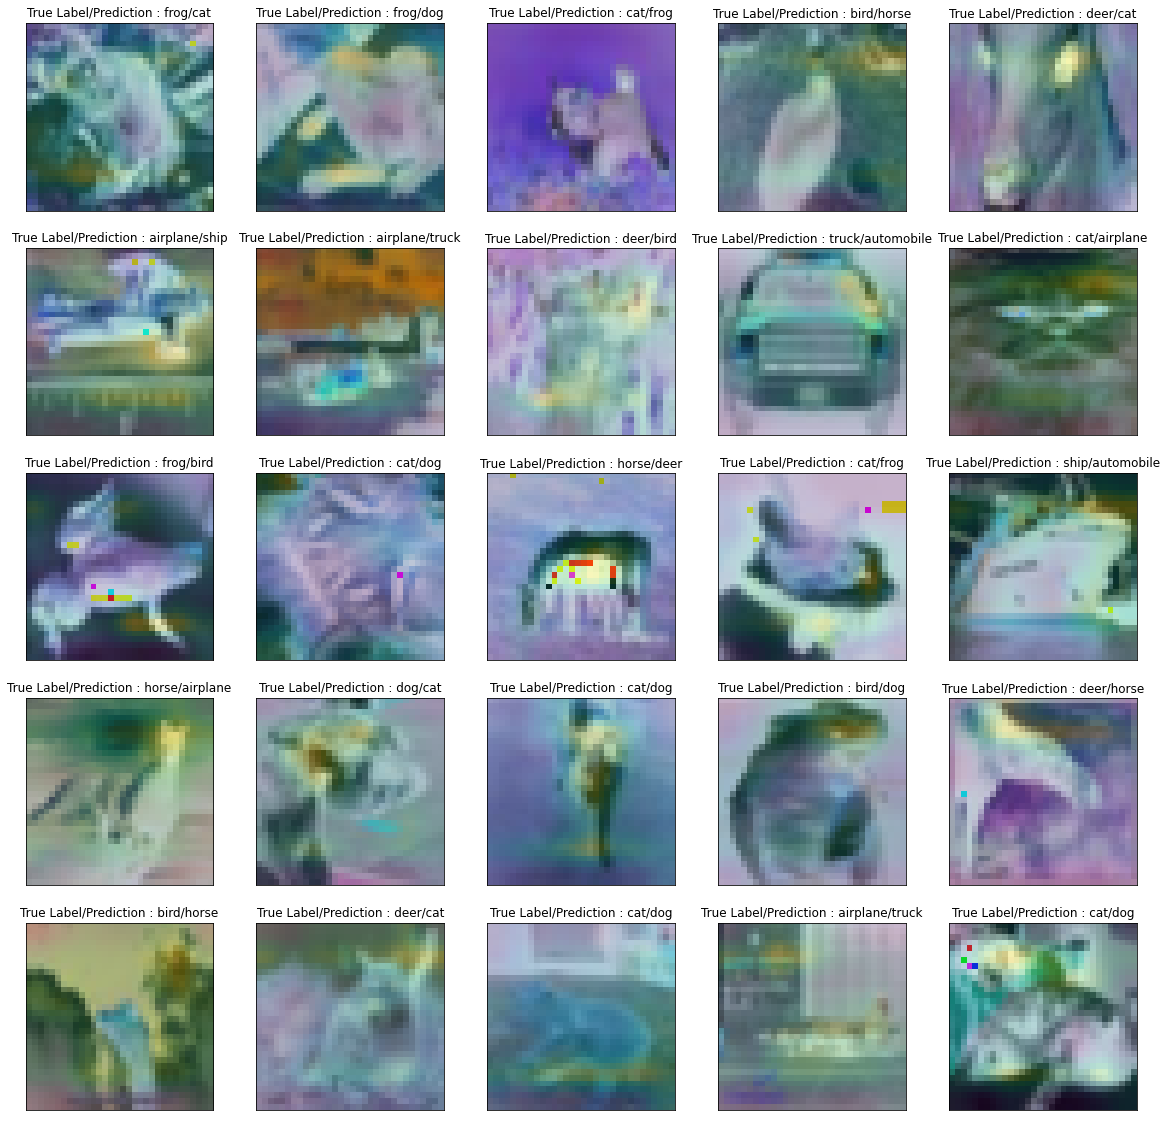

In [76]:
import cv2
import matplotlib.cm as cm 
figr = plt.figure(figsize=(20,20))

np.random.seed(0)
indices = np.random.choice(mislabelled_index, 25, replace=False)

for j in range(len(indices)):
    ax = figr.add_subplot(5, 5, 1 + j, xticks=[], yticks=[])
    last_conv_layer = bestmodel.get_layer("re_lu_7")
    last_conv_layer_model = Model(bestmodel.inputs, last_conv_layer.output)
    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    cin = classifier_input
    for layer_name in ["max_pooling2d_2", "global_max_pooling2d", "flatten", "classifier", "lambda"]:
        cin = bestmodel.get_layer(layer_name)(cin)
    classifier_model = Model(classifier_input, cin)
    with tf.GradientTape() as tape:
        x = test_features[indices[j]]
        x = np.expand_dims(x, axis=0)
        last_conv_layer_output = last_conv_layer_model(x)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        class_idx = tf.argmax(preds[0])
        class_output = preds[:, class_idx]
    
    grads = tape.gradient(class_output, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
    gradcam = np.mean(last_conv_layer_output, axis=-1)
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    img = np.uint8(255 * test_features[indices[j]])
    gradcam = cv2.resize(gradcam, (img.shape[1], img.shape[0]))
    gradcam = np.uint8(255 * gradcam)
    ax.set_title("True Label/Prediction : {}/{}".format(class_names[true_labels[indices[j]]],
                                                        class_names[pred_labels[indices[j]]]))
    plt.imshow(img)
    plt.imshow(gradcam, alpha=0.3)

plt.show()

## Gradio App

In [117]:
def classify_image(img):
    inp = np.expand_dims(img, axis=0)
    prediction = bestmodel.predict(inp)
    class_idx = np.argmax(prediction[0])
    return f"""Class: {class_names[class_idx]}"""

In [118]:
import gradio as gr
face = gr.Interface(fn=classify_image, 
                    inputs=[gr.inputs.Image(shape=(32, 32))],
                    title = "Image Classifier App",
                    description = "Here you can classify images of categories airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck",
                    outputs=["text"])
face.launch(debug=False)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://26567.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f451050a790>,
 'http://127.0.0.1:7861/',
 'https://26567.gradio.app')

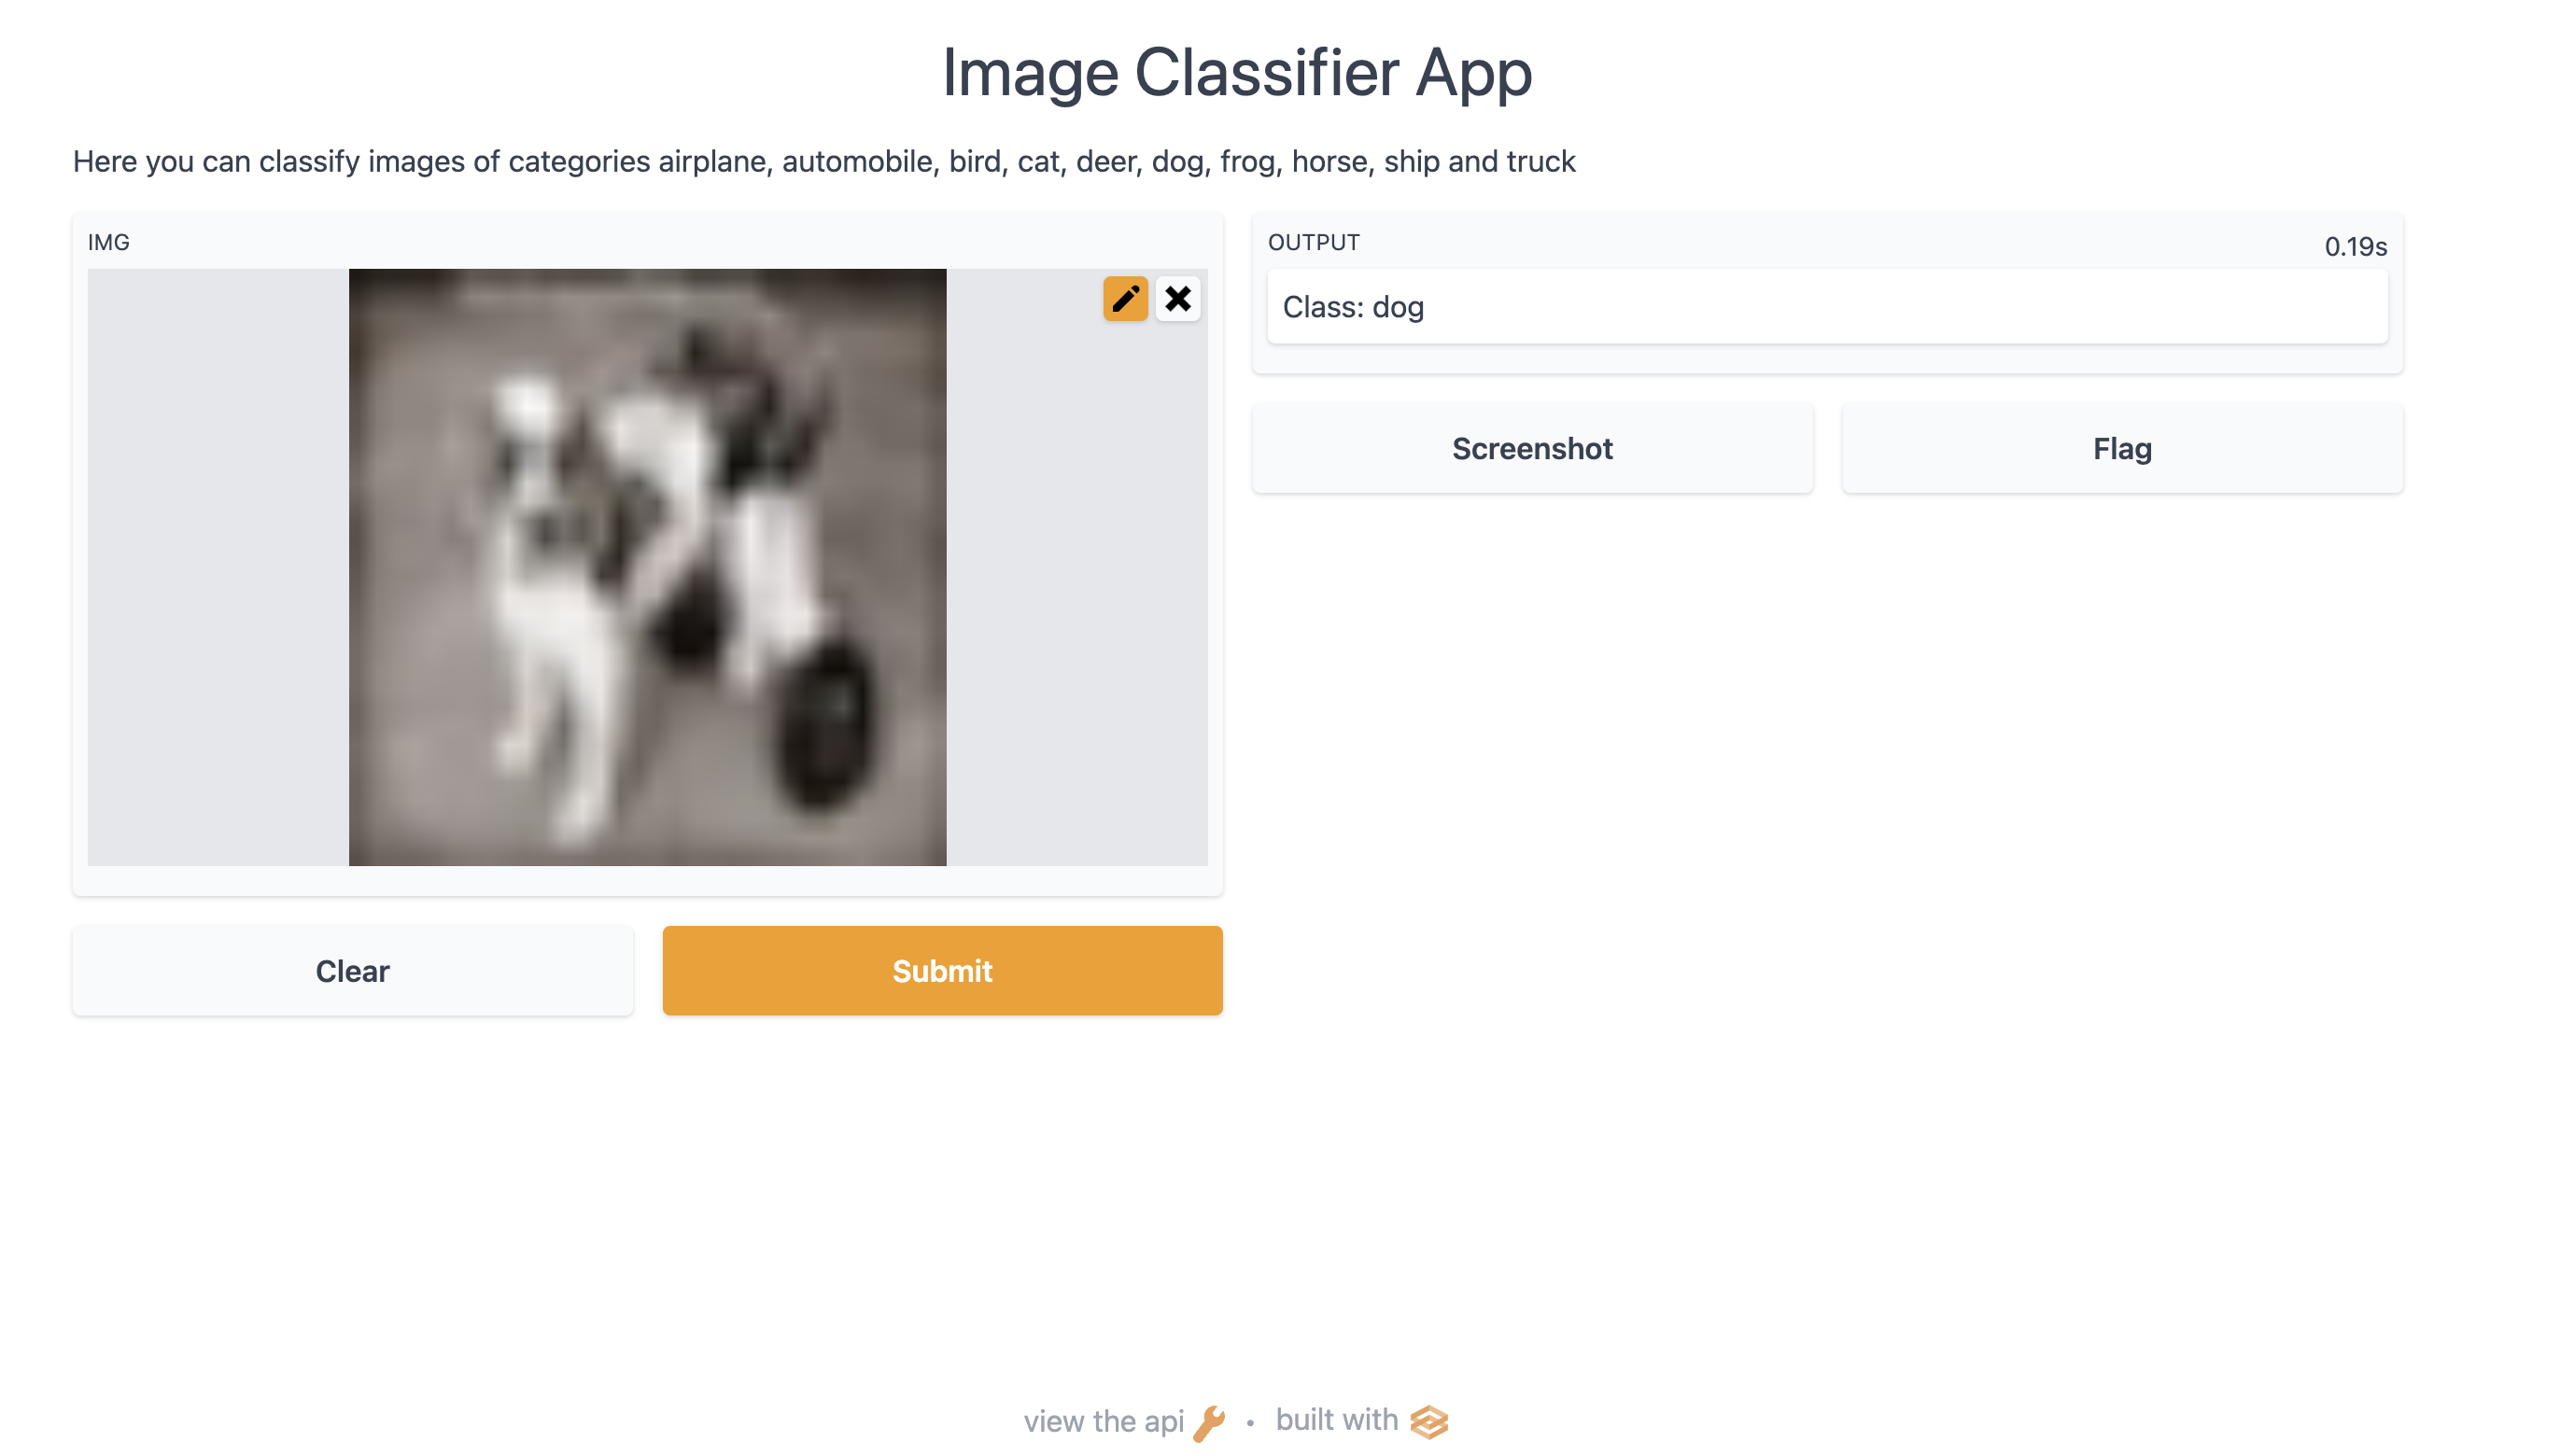